### Подключение библиотек и скриптов

In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import catboost 

%matplotlib inline

### Считывание данных

In [124]:
train_data = pd.read_csv("course_project_train.csv")
test_data = pd.read_csv("course_project_test.csv")

In [125]:
train_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Получение основных сведений о датасете

In [126]:
def get_data_info(data, label):  
    print(f"############## Head for {label} ##############")
    print(data.head())
    print()
    
    print(f"############## Describe for {label} ##############")
    print(data.describe())
    print()
    
    # Проверяем признаки на наличие null значений
    print(f"############## Check {label} for null values ##############")
    print(data.isnull().sum())
    print()
    
    # Проверяем формат для всех признаков
    print(f"############## Check {label} for features types ##############")
    print(data.dtypes)
    print()

### Замена нечисловых значений на числовые

In [127]:
def handle_non_numeric_features(data):
    
    #Home Ownership
    column = "Home Ownership"
    data.loc[data[column] == "Home Mortgage", column] = 0
    data.loc[data[column] == "Rent", column] = 1
    data.loc[data[column] == "Own Home", column] = 2
    data.loc[data[column] == "Have Mortgage", column] = 3

    #Term
    column = "Term"
    data.loc[data[column] == "Short Term", column] = 1
    data.loc[data[column] == "Long Term", column] = 0

    #Years in current job
    column = "Years in current job"
    data.loc[data[column] == "< 1 year", column] = 0
    data.loc[data[column] == "1 year", column] = 1
    data.loc[data[column] == "2 years", column] = 2
    data.loc[data[column] == "3 years", column] = 3
    data.loc[data[column] == "4 years", column] = 4
    data.loc[data[column] == "5 years", column] = 5
    data.loc[data[column] == "6 years", column] = 6
    data.loc[data[column] == "7 years", column] = 7
    data.loc[data[column] == "8 years", column] = 8
    data.loc[data[column] == "9 years", column] = 9
    data.loc[data[column] == "10+ years", column] = 10

    #Purpose
    column = "Purpose"
    data.loc[data[column] == "debt consolidation", column] = 0
    data.loc[data[column] == "other", column] = 1
    data.loc[data[column] == "home improvements", column] = 2
    data.loc[data[column] == "business loan", column] = 3
    data.loc[data[column] == "buy a car", column] = 4
    data.loc[data[column] == "medical bills", column] = 5
    data.loc[data[column] == "major purchase", column] = 6
    data.loc[data[column] == "take a trip", column] = 7
    data.loc[data[column] == "buy house", column] = 8
    data.loc[data[column] == "small business", column] = 9
    data.loc[data[column] == "wedding", column] = 10
    data.loc[data[column] == "moving", column] = 11
    data.loc[data[column] == "educational expenses", column] = 12
    data.loc[data[column] == "vacation", column] = 13
    data.loc[data[column] == "renewable energy", column] = 14
    
    return data

### Восстанавление null значений

In [128]:
def handle_null_features(data):
    columns = data.columns.to_list()
    for column in columns:
        data[column] = data[column].replace(np.nan, data[column].median())
    return data

### Подсчет корреляции и построения корреляционной матрицы

In [129]:
def get_correlation_heatmap(data, label):
    corr_mat = data.corr(method='pearson')
    plt.figure(figsize = (30, 15))
    sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

### Построение графика распределения значений признаков

In [130]:
def get_distribution(data, name_data):
    for feature in data.columns:
        plt.figure(figsize = (10, 5))
        data[feature].hist(bins=50)
        plt.ylabel('Count')
        plt.xlabel(feature)
        plt.title(f'{feature} distribution for {name_data}')
        plt.show()

### Оценка качества обучения модели

In [131]:
def estimate_model(data, model):
    y = data["Credit Default"]
    X = data.drop("Credit Default", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42, stratify=y)
    
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    check_test_train = pd.DataFrame({
        "y_train": y_train.ravel(),
        "y_pred": y_pred_train.flatten(),
    })
    
    y_pred = model.predict(X_test)
    check_test = pd.DataFrame({
        "y_test": y_test.ravel(),
        "y_pred": y_pred.flatten(),
    })
    
    F1_train = f1_score(check_test_train["y_pred"], check_test_train["y_train"])
    print("Значение F1-меры для тренировочных данных: ", F1_train)
    
    F1 = f1_score(check_test["y_pred"], check_test["y_test"])
    print("Значение F1-меры для тестовых данных: ", F1)
    print()
    print("Classification report for train")
    print(classification_report(y_train, y_pred_train))
    print()
    print("Classification report for test")
    print(classification_report(y_test, y_pred))
    
    return model, X_train

### Обучение модели

In [132]:
def estimate_gradient_boosting_classifier(data):
    disbalance = data['Credit Default'].value_counts()[0] / data['Credit Default'].value_counts()[1]
    model = catboost.CatBoostClassifier(silent=True, random_state=42, class_weights=[1, disbalance], eval_metric='F1', 
                                        max_depth=2, early_stopping_rounds=20, custom_metric=['Precision', 'Recall'])
    return estimate_model(data, model)

### Получение информации о данных

In [133]:
get_data_info(train_data, "train_data")
get_data_info(test_data, "test_data")

############## Head for train_data ##############
  Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0             

### Просмотр количества различных значений по каждому признаку

In [134]:
columns = train_data.columns.tolist()
for column in columns:
    print(column)
    print(train_data[column].value_counts())
    print()
    
    
columns = test_data.columns.tolist()
for column in columns:
    print(column)
    print(test_data[column].value_counts())
    print()

Home Ownership
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Annual Income
1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64

Years in current job
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

Tax Liens
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

Number of Open Accounts
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0   

# Обработка данных

Удаление выбросов

In [135]:
train_data.loc[train_data["Monthly Debt"] > 75000, "Monthly Debt"] = train_data["Monthly Debt"].mean()
test_data.loc[test_data["Monthly Debt"] > 75000, "Monthly Debt"] = test_data["Monthly Debt"].mean()

train_data.loc[train_data["Years of Credit History"] > 50, "Years of Credit History"] = train_data["Years of Credit History"].mean()
test_data.loc[test_data["Years of Credit History"] > 50, "Years of Credit History"] = test_data["Years of Credit History"].mean()

train_data.loc[train_data["Current Loan Amount"] > train_data["Maximum Open Credit"], "Current Loan Amount"] = train_data["Maximum Open Credit"]
test_data.loc[test_data["Current Loan Amount"] > test_data["Maximum Open Credit"], "Current Loan Amount"] = test_data["Maximum Open Credit"]

Создание dummy-переменных

In [136]:
train_data = pd.concat([train_data, pd.get_dummies(train_data['Home Ownership'])], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Home Ownership'])], axis=1)
pd.get_dummies(train_data['Home Ownership'])

,Have Mortgage,Home Mortgage,Own Home,Rent
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1
...,...,...,...,...
7495,0,0,0,1
7496,0,1,0,0
7497,0,0,0,1
7498,0,1,0,0


In [137]:
train_data['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [138]:
train_income_max = train_data['Annual Income'].max()

def income_to_cat(data):
    bins = [0, 9.311330e+05, 1.168386e+06, 1.499974e+06, train_income_max]
    data['income_cat'] = pd.cut(data['Annual Income'], bins=bins, labels=False)
    data['income_cat'].fillna(data['income_cat'].mean(), inplace=True)
    return data

In [139]:
train_data = income_to_cat(train_data)
test_data = income_to_cat(test_data)
train_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent,income_cat
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,685960.0,47386.0,7914.0,749.0,0,0,0,1,0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,264968.0,394972.0,18373.0,737.0,1,0,0,1,0,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,1182434.0,308389.0,13651.0,742.0,0,0,1,0,0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,121396.0,95855.0,11338.0,694.0,0,0,0,1,0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,125840.0,93309.0,7180.0,719.0,0,0,0,0,1,0.0


In [140]:
df_cat = train_data.groupby('income_cat', as_index=False).median()[['income_cat', 'Current Loan Amount']].rename(columns={
    'Current Loan Amount': 'current_encode_income'
})
df_cat = pd.DataFrame(df_cat)

df_cat
train_data["Annual Income"]
train_data = train_data.merge(df_cat, on='income_cat', how='left')
test_data = test_data.merge(df_cat, on='income_cat', how='left')

Объединение количества проблем с кредитом и банкротств

In [141]:
df_cat = train_data.groupby('Bankruptcies', as_index=False).median()[['Bankruptcies', 'Number of Credit Problems']].rename(columns={
    'Number of Credit Problems': 'bankrup_encode_prolems'
})
df_cat = pd.DataFrame(df_cat)

df_cat.head()
train_data = train_data.merge(df_cat, on='Bankruptcies', how='left')
test_data = test_data.merge(df_cat, on='Bankruptcies', how='left')
train_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Monthly Debt,Credit Score,Credit Default,Have Mortgage,Home Mortgage,Own Home,Rent,income_cat,current_encode_income,bankrup_encode_prolems
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,7914.0,749.0,0,0,0,1,0,0.0,184558.0,1.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,18373.0,737.0,1,0,0,1,0,1.0,262988.0,0.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,13651.0,742.0,0,0,1,0,0,0.0,184558.0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,11338.0,694.0,0,0,0,1,0,0.0,184558.0,1.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,7180.0,719.0,0,0,0,0,1,0.0,184558.0,0.0


Объединение количества проблем с кредитом и банкротств

In [142]:
train_data['ratio_loan_to_max'] = train_data['Current Loan Amount'] / train_data['Maximum Open Credit']
test_data['ratio_loan_to_max'] = test_data['Current Loan Amount'] / test_data['Maximum Open Credit']

In [143]:
train_data["Credit Score"].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

Перевод "Credit Score" в категориальные переменные

In [144]:
train_credit_score_max = train_data["Credit Score"].max()

def score_to_cat(data):
    bins = [0, 600, 700, train_credit_score_max]
    data['score_cat'] = pd.cut(data['Credit Score'], bins=bins, labels=False)
    data['score_cat'].fillna(data['score_cat'].median(), inplace=True)
    return data
train_data = score_to_cat(train_data)
test_data = score_to_cat(test_data)

Объединение количества проблем с кредитом и банкротств

In [145]:
df_cat = train_data.groupby('score_cat', as_index=False).mean()[['score_cat', 'Credit Default']].rename(columns={
    'Credit Default': 'score_encode_default'
})
df_cat = pd.DataFrame(df_cat)

df_cat.head()

,score_cat,score_encode_default
0,0.0,0.571429
1,1.0,0.350980
2,2.0,0.270182


In [146]:
train_data = train_data.merge(df_cat, on='score_cat', how='left')
test_data = test_data.merge(df_cat, on='score_cat', how='left')
train_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Have Mortgage,Home Mortgage,Own Home,Rent,income_cat,current_encode_income,bankrup_encode_prolems,ratio_loan_to_max,score_cat,score_encode_default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,0,0,1,0,0.0,184558.0,1.0,1.000000,2.0,0.270182
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,0,0,1,0,1.0,262988.0,0.0,0.224220,2.0,0.270182
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,0,1,0,0,0.0,184558.0,0.0,1.000000,2.0,0.270182
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,0,0,1,0,0.0,184558.0,1.0,0.823582,1.0,0.350980
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,0,0,0,1,0.0,184558.0,0.0,0.326149,2.0,0.270182


Процент обязательств от дохода

In [147]:
train_data['year_perc_income'] = 1 - 12 * train_data['Monthly Debt'] / train_data['Annual Income']
test_data['year_perc_income'] = 1 - 12 * test_data['Monthly Debt'] / test_data['Annual Income']

Удаление малозначимых признаков

In [148]:
train_data = train_data.drop("Have Mortgage", axis=1)
test_data = test_data.drop("Have Mortgage", axis=1)
train_data = train_data.drop("Home Mortgage", axis=1)
test_data = test_data.drop("Home Mortgage", axis=1)

# Замена нечисловых значений на числовые и восстановление nan значений

In [149]:
handle_non_numeric_features(train_data)
handle_non_numeric_features(test_data)
handle_null_features(train_data)
handle_null_features(test_data)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Own Home,Rent,income_cat,current_encode_income,bankrup_encode_prolems,ratio_loan_to_max,score_cat,score_encode_default,year_perc_income
0,1,1178475.0,4.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,731.0,0,1,1.50504,301356.0,0.0,0.735265,2.0,0.270182,0.829007
1,1,231838.0,1.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,...,699.0,0,1,0.00000,184558.0,0.0,1.000000,1.0,0.350980,0.880020
2,0,1152540.0,3.0,0.0,10.0,13.7,204600.0,0.0,30.0,0.0,...,7260.0,0,0,1.00000,262988.0,0.0,0.978387,2.0,0.270182,0.804998
3,0,1220313.0,10.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,739.0,0,0,2.00000,301356.0,0.0,0.476399,2.0,0.270182,0.728997
4,0,2340952.0,6.0,0.0,11.0,23.6,1207272.0,0.0,30.0,0.0,...,706.0,0,0,3.00000,405416.0,0.0,0.644125,2.0,0.270182,0.781602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0,1020053.0,10.0,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,...,745.0,0,0,1.00000,262988.0,1.0,1.000000,2.0,0.270182,0.822997
2496,0,1178475.0,2.0,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,...,731.0,0,0,1.50504,301356.0,0.0,0.269604,2.0,0.270182,0.829007
2497,0,1171806.0,2.0,0.0,48.0,12.8,1706430.0,0.0,30.0,0.0,...,695.0,0,0,2.00000,301356.0,0.0,0.252279,1.0,0.350980,0.621999
2498,1,723520.0,10.0,0.0,14.0,28.8,945780.0,0.0,30.0,0.0,...,744.0,0,1,0.00000,184558.0,0.0,0.272552,2.0,0.270182,0.775995


In [150]:
train_data.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Own Home', 'Rent', 'income_cat',
       'current_encode_income', 'bankrup_encode_prolems', 'ratio_loan_to_max',
       'score_cat', 'score_encode_default', 'year_perc_income'],
      dtype='object')

### Построение распределения каждого признака

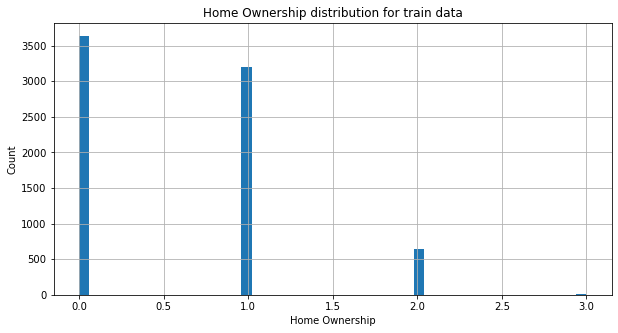

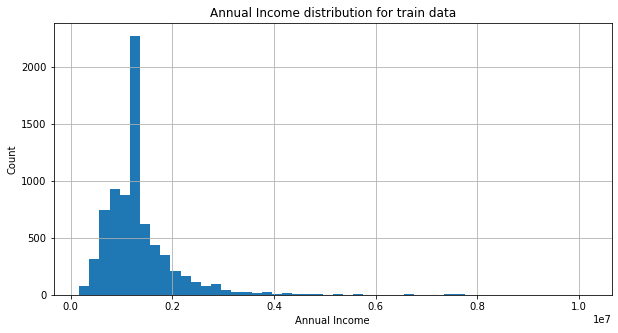

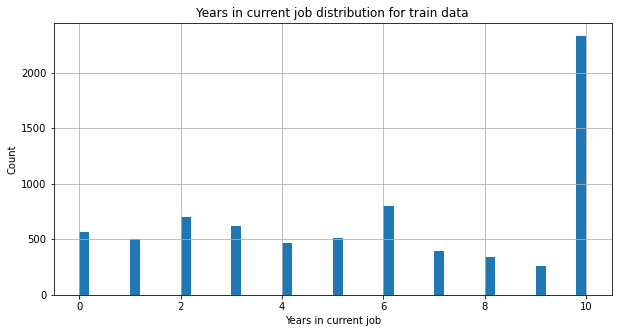

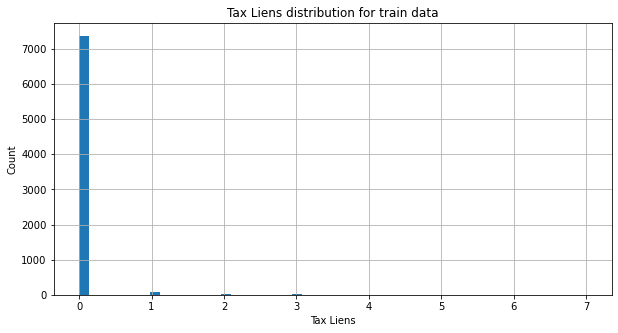

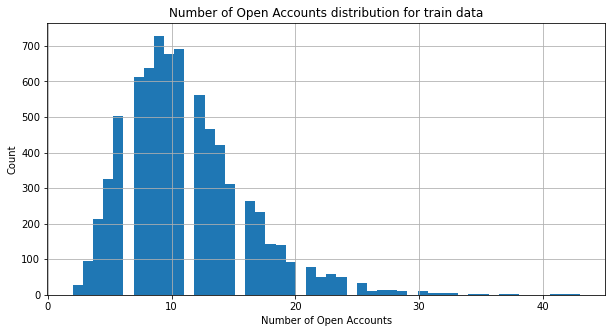

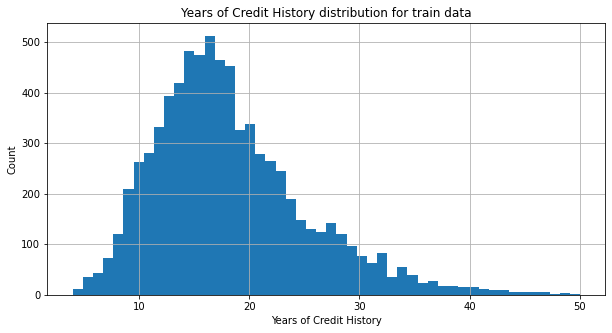

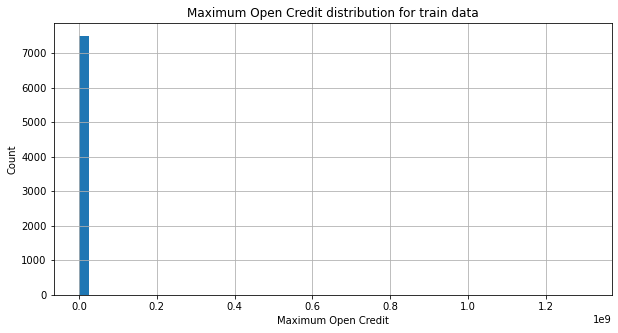

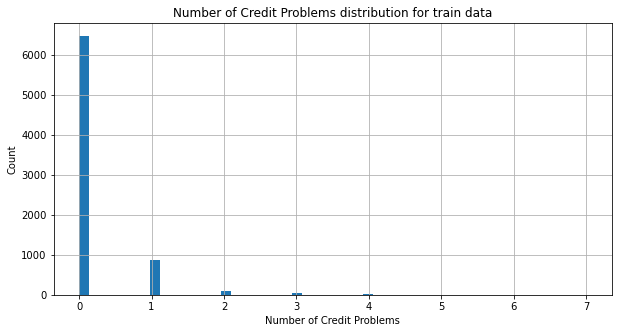

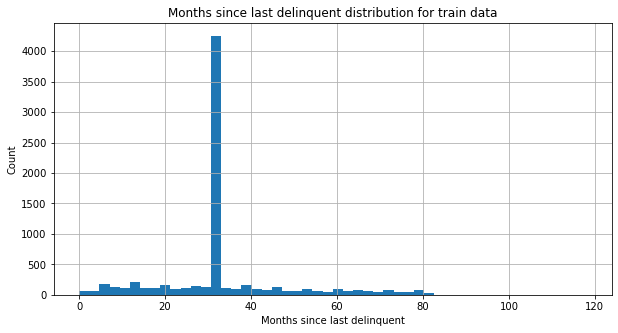

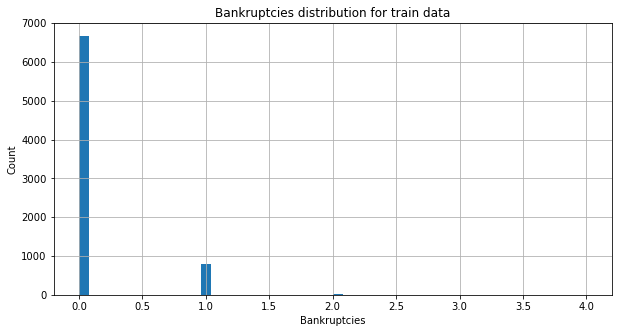

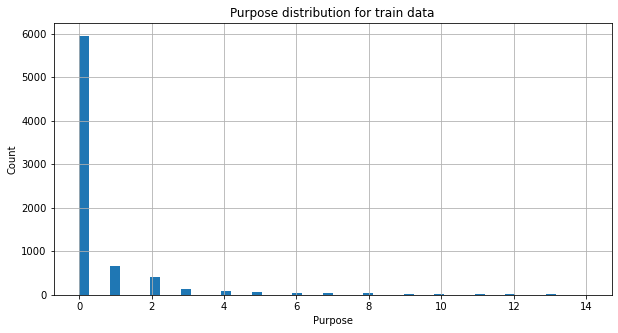

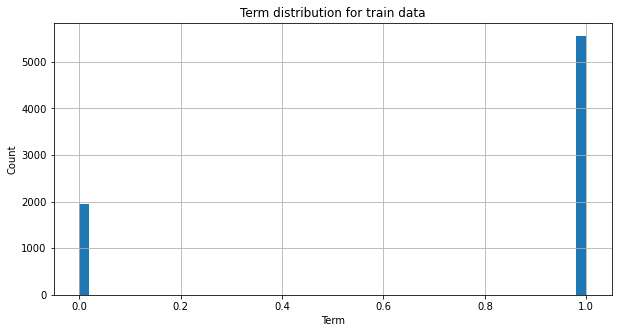

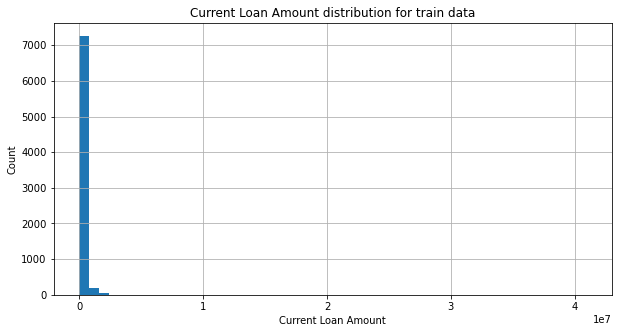

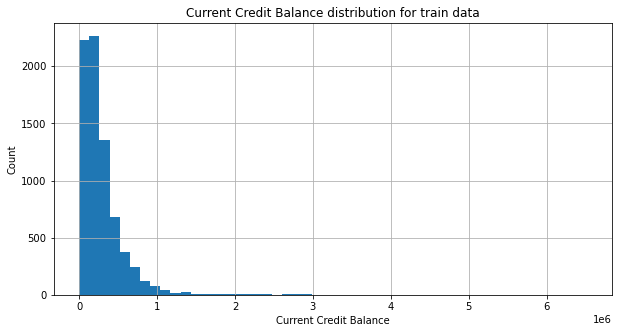

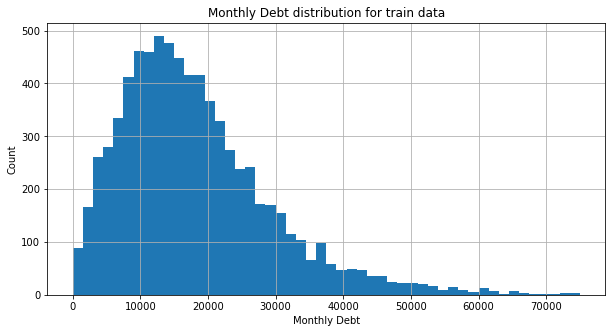

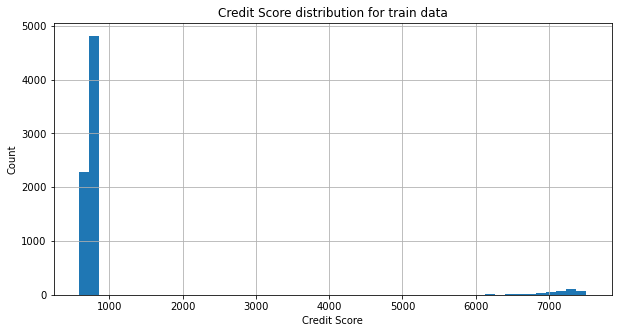

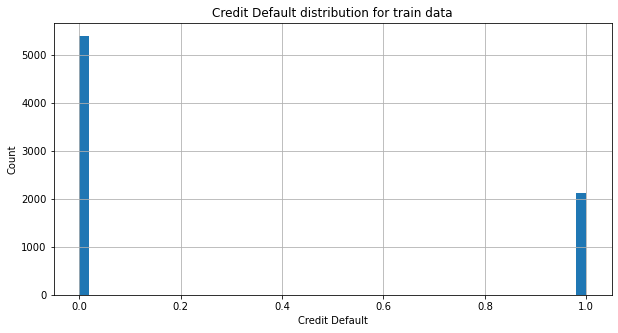

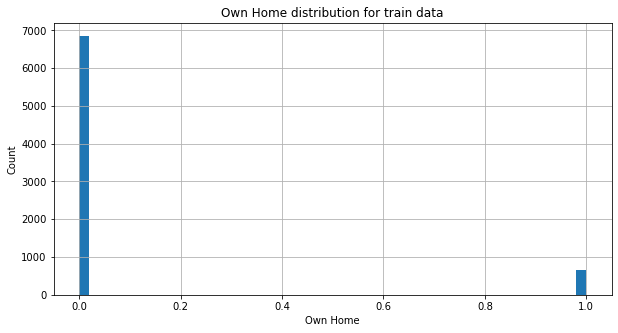

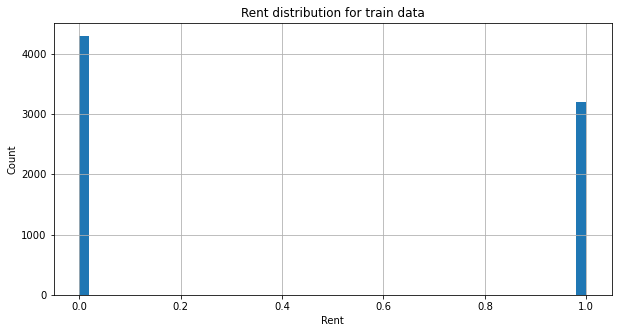

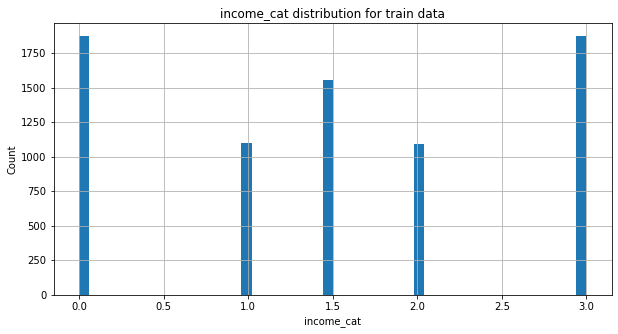

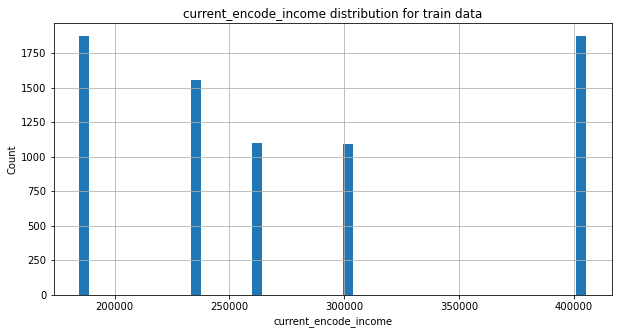

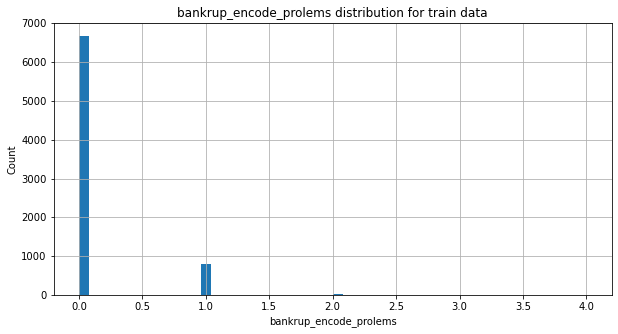

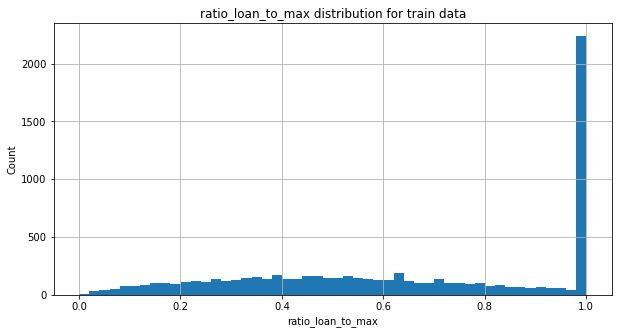

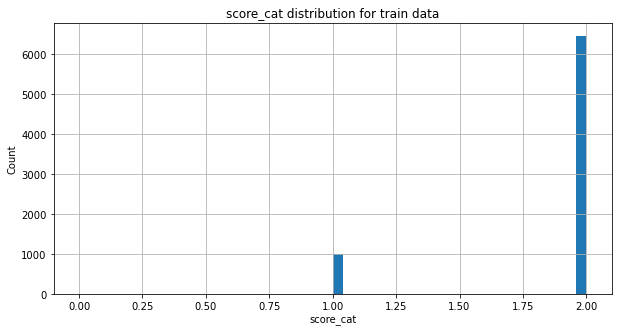

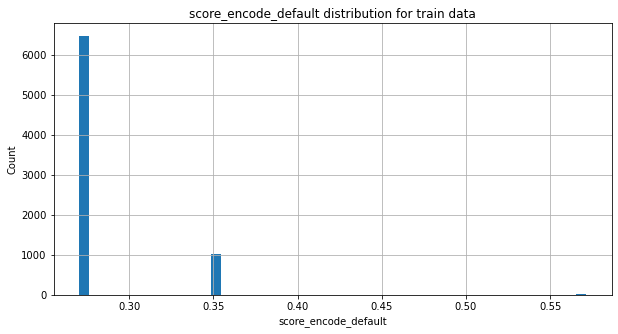

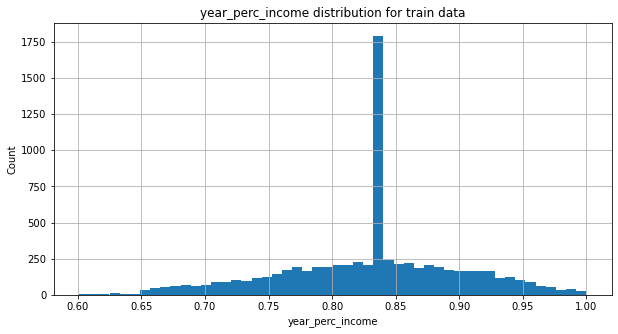

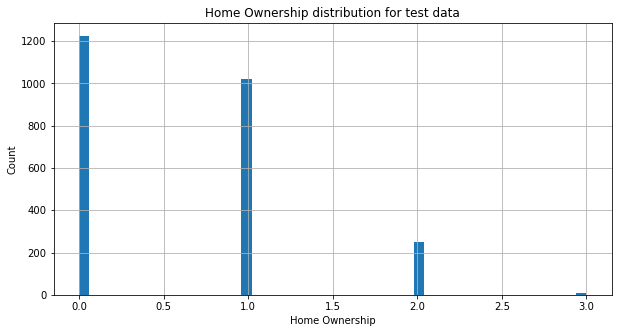

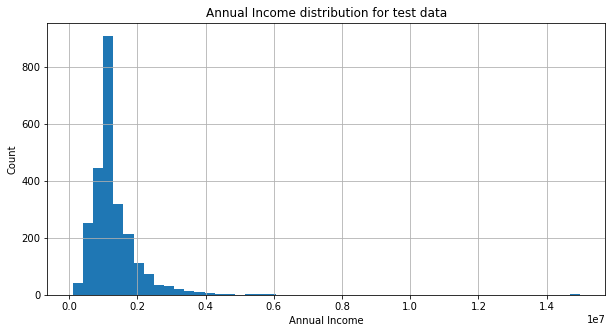

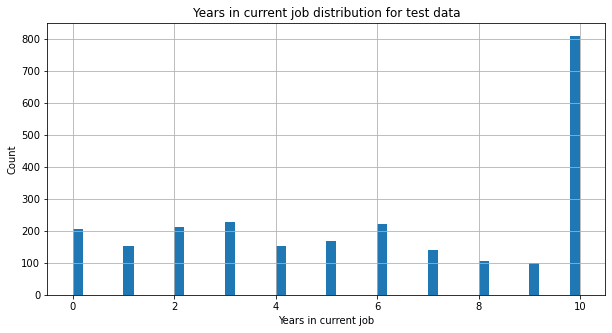

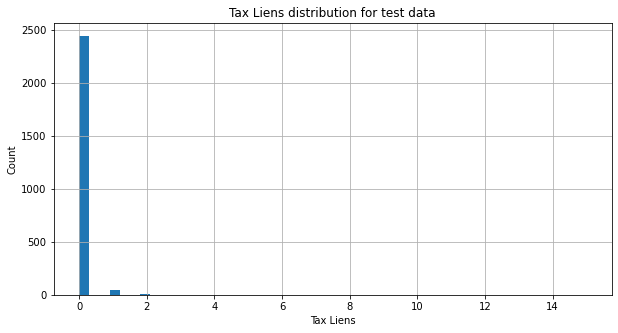

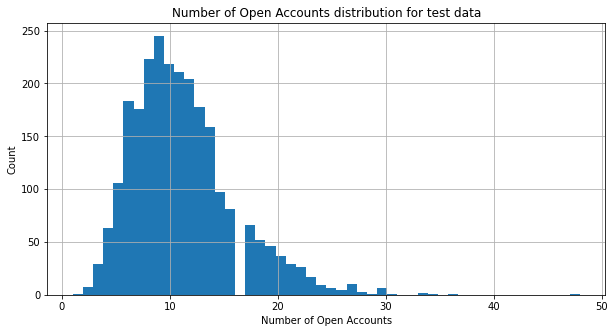

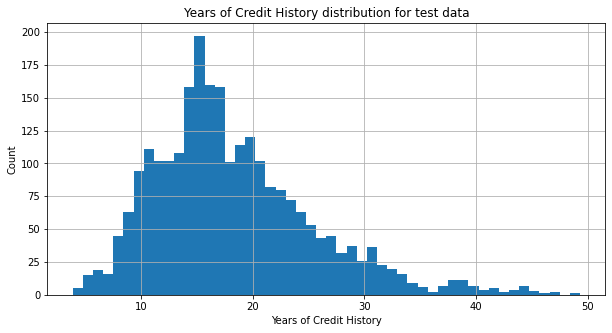

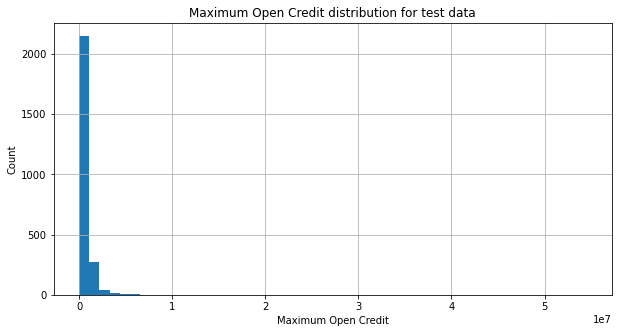

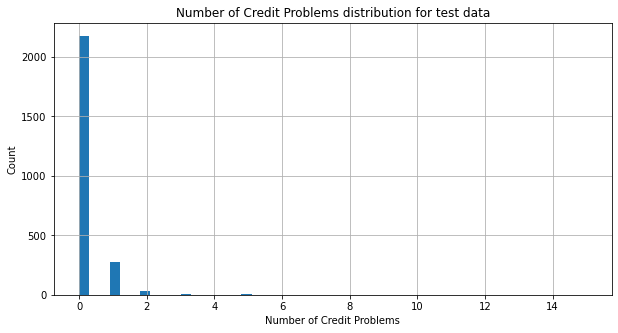

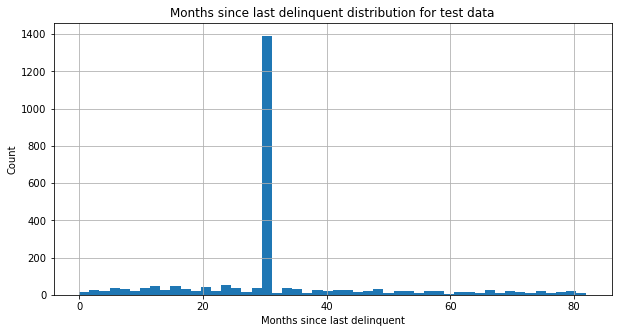

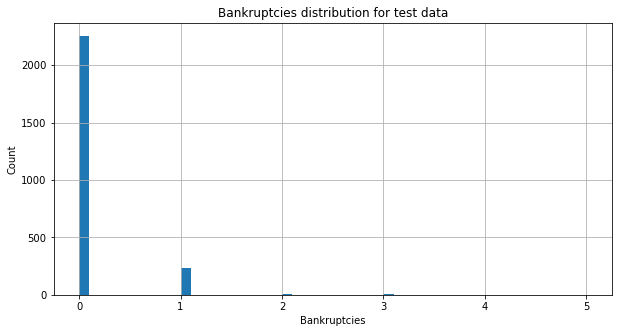

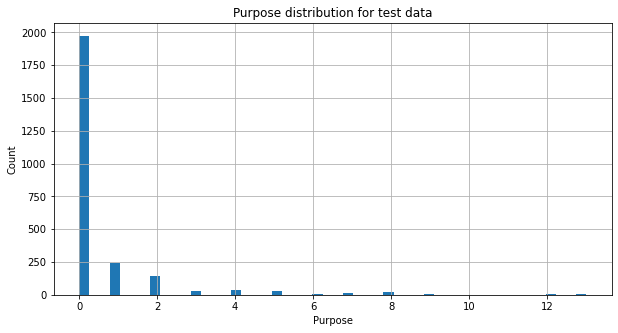

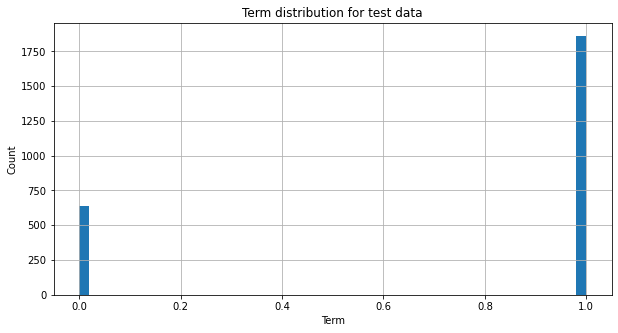

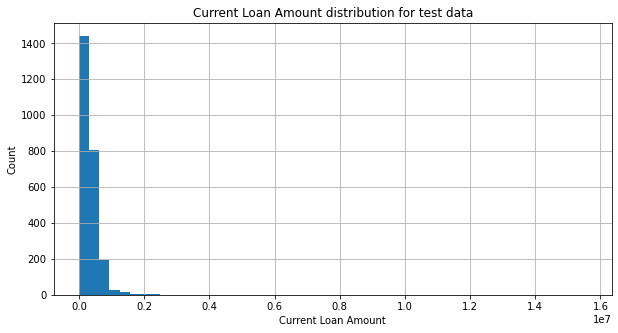

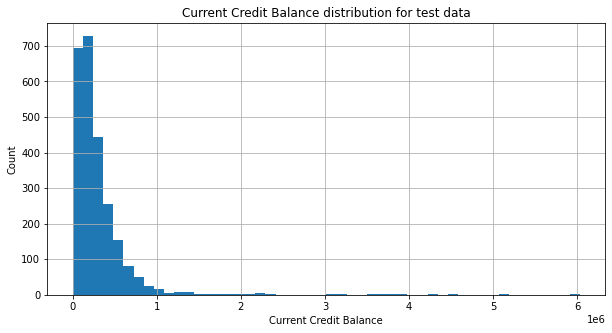

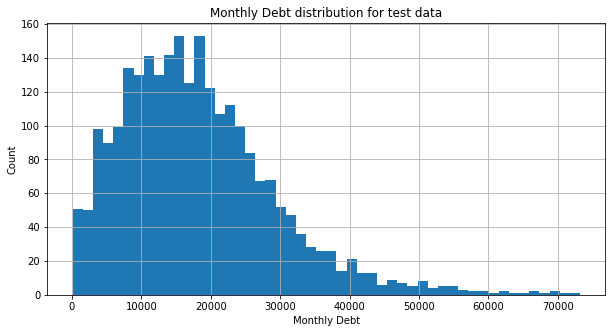

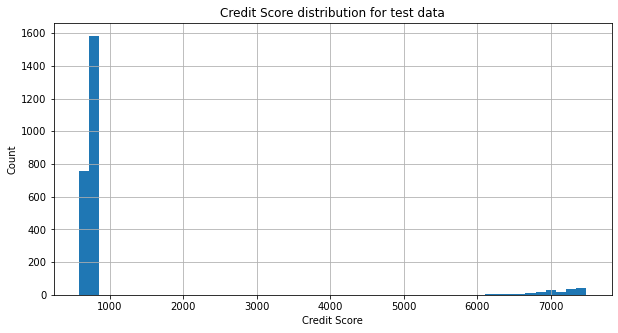

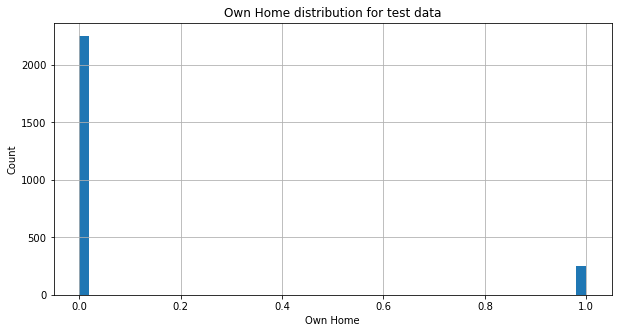

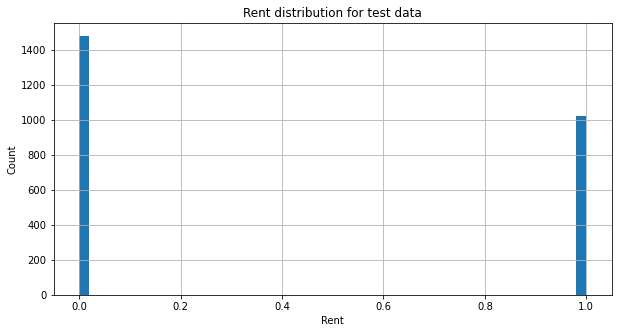

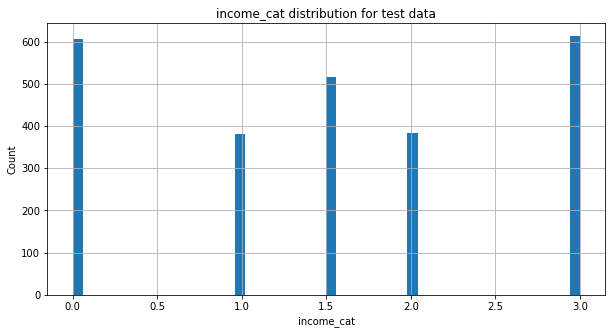

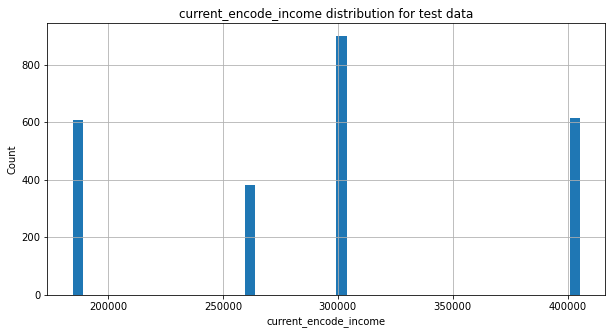

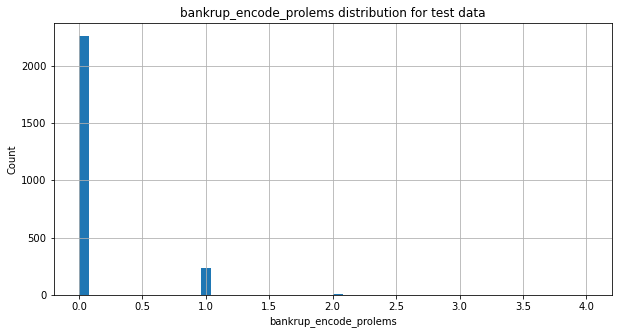

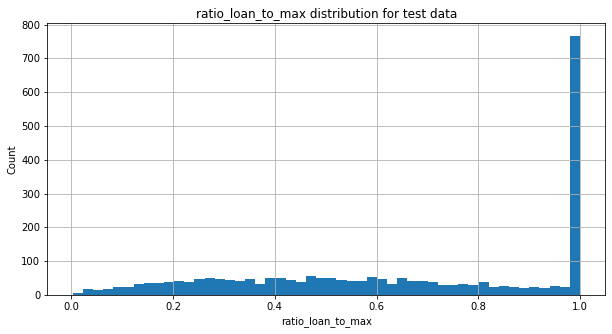

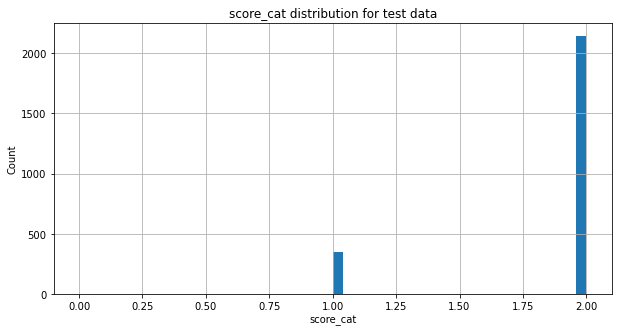

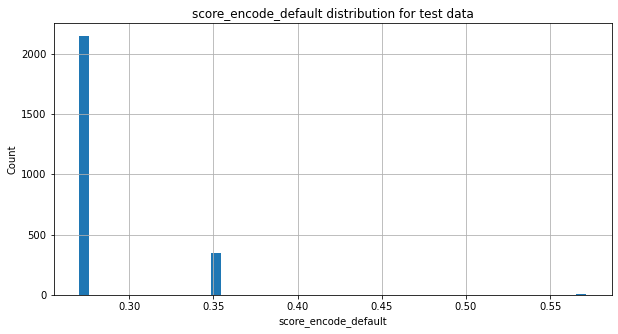

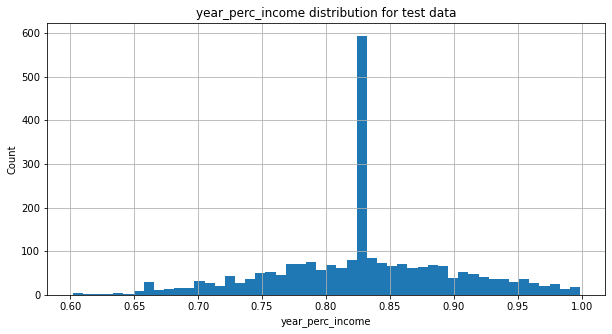

In [151]:
get_distribution(train_data, "train data")
get_distribution(test_data, "test data")

### Построение корреляционной матрицы

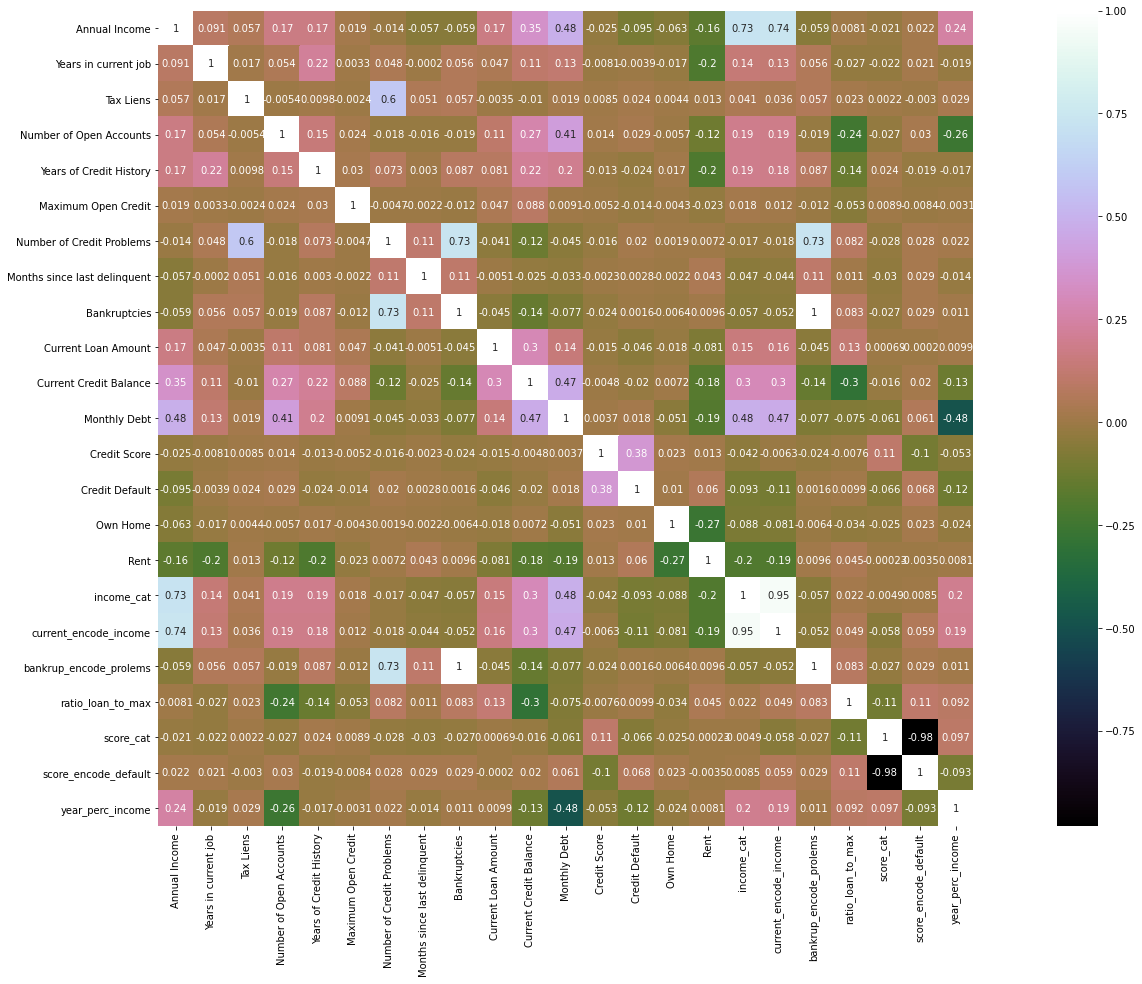

In [152]:
get_correlation_heatmap(train_data, "train_data")

### Построениe модели

In [153]:
model, X_train = estimate_gradient_boosting_classifier(train_data)
y_pred = model.predict(test_data)

Значение F1-меры для тренировочных данных:  0.6025316455696202
Значение F1-меры для тестовых данных:  0.5328836424957842

Classification report for train
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4040
           1       0.54      0.68      0.60      1585

    accuracy                           0.75      5625
   macro avg       0.70      0.73      0.71      5625
weighted avg       0.77      0.75      0.76      5625


Classification report for test
              precision    recall  f1-score   support

           0       0.83      0.75      0.78      1347
           1       0.48      0.60      0.53       528

    accuracy                           0.70      1875
   macro avg       0.65      0.67      0.66      1875
weighted avg       0.73      0.70      0.71      1875



In [154]:
result = pd.DataFrame({"Id": test_data.index, "Credit Default": y_pred})
result.to_csv(r'Klimova_results.csv', index=False, header=True)

### Выявление наиболее важных признаков

In [155]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), columns=['feature_name','importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
15,Credit Score,70.778734
12,Current Loan Amount,8.085147
11,Term,4.017192
24,year_perc_income,2.814561
21,ratio_loan_to_max,2.216042
1,Annual Income,2.101290
6,Maximum Open Credit,1.669055
13,Current Credit Balance,1.393783
19,current_encode_income,1.034650
14,Monthly Debt,0.947390
